In [ ]:
!pip install opendatasets
!pip install contractions
!pip install autocorrect
!pip install openpyxl -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=6ce58d2a745b04d4a5c1715c985da3cf1f5e7695db16f0004136a1c13ab3efda
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [ ]:

# library imports
import pandas as pd
import opendatasets
import contractions
from autocorrect import Speller
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import nltk
import re

In [ ]:
tqdm_notebook.pandas()


In [ ]:

# load the dataset
raw_data = pd.read_excel('/content/classifier new (2).xlsx')

In [ ]:
raw_data .columns

Index(['Sentences', 'OpinionTerm1', 'Aspect Category1', 'AspectPolarity1 ',
       'OpinionTerm2', 'Aspect Category2', 'Aspectpolarity2'],
      dtype='object')

In [ ]:
mapping = {
    'Company_Service': 'Company_Service',
    'App_Utility': 'App_Utility',
    'service_quality': 'service_quality',
    'service_person_attitude': 'service_person_attitude',
    'Cost': 'Cost',
    'App_UI': 'App_UI',
    'App_Functionality': 'App_Functionality',
    'service_schedule': 'service_schedule',
    'Customer_Support': 'Customer_Support',
    'cost': 'Cost',
    'Company_service': 'Company_Service',
    'Payment': 'Payment',
    'payment': 'Payment',
    'Customer_Suppor': 'Customer_Support'
}

# Replace variations with the standard name
raw_data['Aspect Category1'] = raw_data['Aspect Category1'].map(mapping)

In [ ]:
raw_data.columns = raw_data.columns.str.strip()

In [ ]:
print(raw_data['AspectPolarity1'].unique())


['positive' 'negative ' 'Positive' 'positive ']


In [ ]:
# Assuming raw_data is your DataFrame

# Mapping with variations
mapping = {
    'positive': 'positive',
    'Positive': 'positive',
    'positive ': 'positive',
    'positive  ': 'positive',  # Add more variations as needed
    'negative': 'negative',
    'Negative': 'negative',
    'negative ': 'negative',
    'negative  ': 'negative'  # Add more variations as needed
}

# Apply the mapping after converting to lowercase for case-insensitivity
raw_data['AspectPolarity1'] = raw_data['AspectPolarity1'].str.lower().map(mapping)

# Check unique values
unique_values = raw_data['AspectPolarity1'].unique()
print(unique_values)



['positive' 'negative']


In [ ]:
raw_data['AspectPolarity1'].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:

# define observation counts within each class
class_counts = raw_data['Aspect Category1'].value_counts()

In [ ]:
class_counts

Company_Service            2366
App_Utility                 578
service_quality             574
service_person_attitude     189
Cost                        136
App_UI                       74
App_Functionality            66
service_schedule             51
Customer_Support             50
Payment                       9
Name: Aspect Category1, dtype: int64

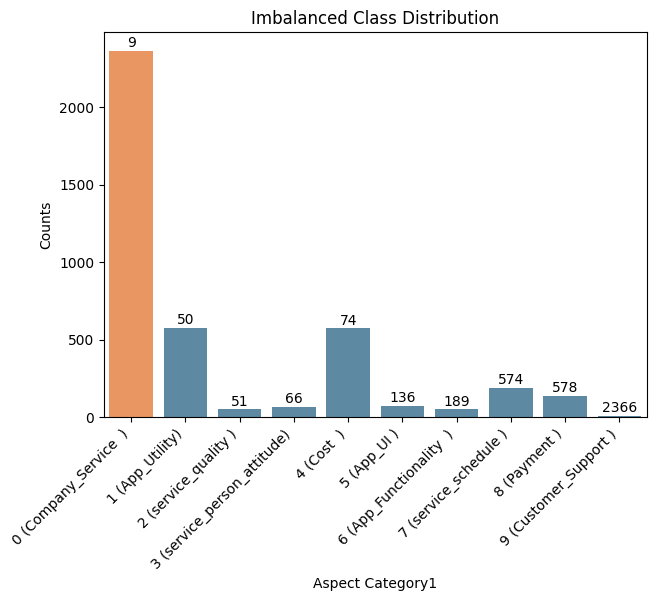

In [ ]:
# display a bar chart of the distribution
plt.figure(figsize = (7, 5))

# define colors
colors = ['#528CAD' if (x < max(class_counts)) else '#FF914D' for x in class_counts]

ax = sns.countplot(x=raw_data['Aspect Category1'],
                   data=raw_data,
                   palette=colors)
ax.set(title='Imbalanced Class Distribution')

# place labels above each bar
vals = class_counts.to_list()
vals.sort()
ax_labels = vals
rects = ax.patches
labels = [ax_labels[i] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

# edit x-tick labels
ax.set_xticklabels(['0 (Company_Service  )', "1 (App_Utility)","2 (service_quality )","3 (service_person_attitude)","4 (Cost  )","5 (App_UI )","6 (App_Functionality  )","7 (service_schedule )","8 (Payment )","9 (Customer_Support )"],rotation=45, ha="right")

# y-axis label
ax.set_ylabel("Counts")

plt.show()

**Handling both catgories and polrity**

In [ ]:
from sklearn.utils import resample
import pandas as pd
import numpy as np

# Assuming raw_data is your DataFrame

# List of categories to upsample
categories_to_upsample = ['App_Utility', 'service_quality', 'service_person_attitude', 'Cost', 'App_UI', 'App_Functionality', 'service_schedule', 'Customer_Support', 'Payment']

# Unique values in the 'polarity' column (assuming it has two values, e.g., 'positive' and 'negative')
polarity_values = ['positive', 'negative']

# Empty DataFrame to store the upsampled data
upsampled_data = pd.DataFrame()

np.random.seed(42)

for category in categories_to_upsample:
    for polarity_value in polarity_values:
        # Calculate the number of samples needed for each category and polarity
        target_count = np.random.randint(2000, 2501)

        # Upsample the minority class for each category and polarity
        upsampled_category_polarity = resample(
            raw_data[(raw_data['Aspect Category1'] == category) & (raw_data['AspectPolarity1'] == polarity_value)],
            replace=True,
            n_samples=target_count,
            random_state=42
        )

        # Concatenate the upsampled category and polarity with the rest of the data
        upsampled_data = pd.concat([upsampled_data, upsampled_category_polarity])

# Combine the upsampled minority classes with the rest of the data
dataset = pd.concat([raw_data[~raw_data['Aspect Category1'].isin(categories_to_upsample)], upsampled_data])

# Print the count after upsampling for each category and polarity
for category in categories_to_upsample:
    for polarity_value in polarity_values:
        count = len(upsampled_data[(upsampled_data['Aspect Category1'] == category) & (upsampled_data['AspectPolarity1'] == polarity_value)])
        print(f"Count of '{category}' examples with '{polarity_value}' polarity (after upsampling): {count}")

# Print the total count after upsampling
print(f"Total count after upsampling: {len(dataset)}")


Count of 'App_Utility' examples with 'positive' polarity (after upsampling): 2102
Count of 'App_Utility' examples with 'negative' polarity (after upsampling): 2435
Count of 'service_quality' examples with 'positive' polarity (after upsampling): 2348
Count of 'service_quality' examples with 'negative' polarity (after upsampling): 2270
Count of 'service_person_attitude' examples with 'positive' polarity (after upsampling): 2106
Count of 'service_person_attitude' examples with 'negative' polarity (after upsampling): 2071
Count of 'Cost' examples with 'positive' polarity (after upsampling): 2188
Count of 'Cost' examples with 'negative' polarity (after upsampling): 2020
Count of 'App_UI' examples with 'positive' polarity (after upsampling): 2102
Count of 'App_UI' examples with 'negative' polarity (after upsampling): 2121
Count of 'App_Functionality' examples with 'positive' polarity (after upsampling): 2466
Count of 'App_Functionality' examples with 'negative' polarity (after upsampling): 2

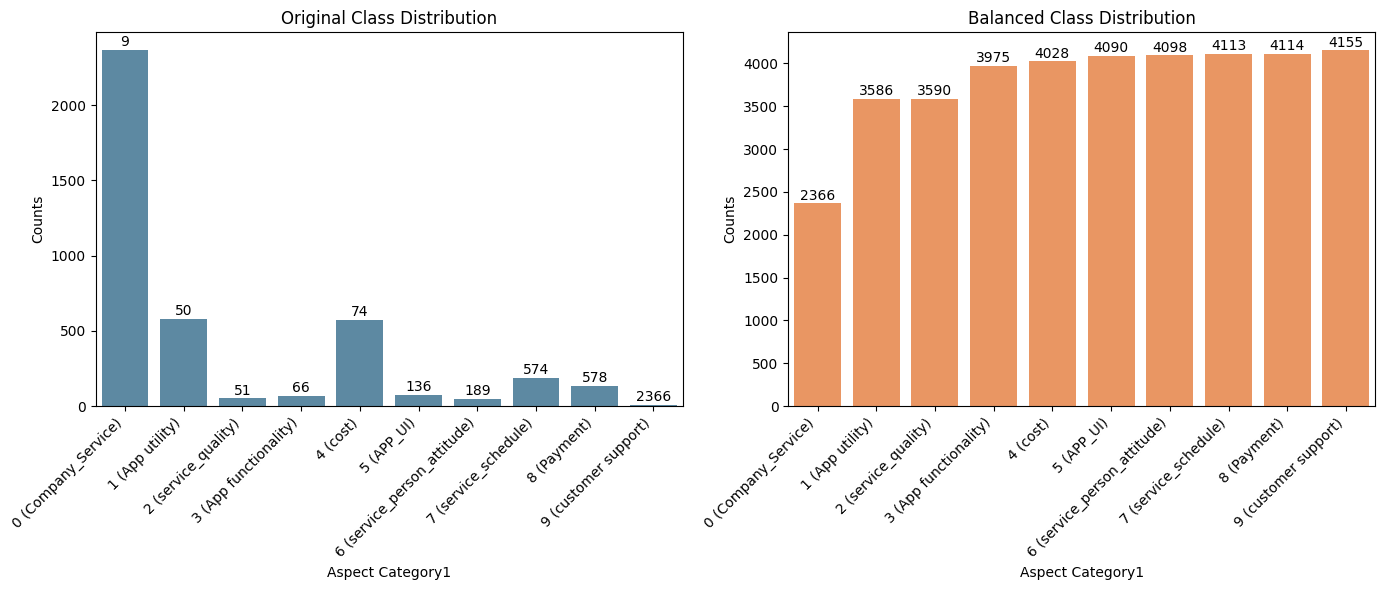

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Aspect Category1' is the column with class labels in your 'raw_data'
class_counts_original = raw_data['Aspect Category1'].value_counts()
class_counts_upsampled = dataset['Aspect Category1'].value_counts()

# Plot for the original data
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 2, 1)

# define colors for the original data
colors_original = ['#528CAD' for _ in class_counts_original]

sns.countplot(x=raw_data['Aspect Category1'], data=raw_data, palette=colors_original, ax=ax1)
ax1.set(title='Original Class Distribution')

# Set tick locations based on the number of unique classes
ax1.set_xticks(range(len(class_counts_original)))

# Edit x-tick labels
ax1.set_xticklabels(['0 (Company_Service)', "1 (App utility)", "2 (service_quality)", "3 (App functionality)",
                     "4 (cost)", "5 (APP_UI)", "6 (service_person_attitude)", "7 (service_schedule)",
                     "8 (Payment)", "9 (customer support)"], rotation=45, ha="right")

# Place labels above each bar
vals_original = class_counts_original.to_list()
vals_original.sort()
ax_labels_original = vals_original
rects_original = ax1.patches
labels_original = [ax_labels_original[i] for i in range(len(rects_original))]

for rect, label in zip(rects_original, labels_original):
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

# y-axis label
ax1.set_ylabel("Counts")

# Plot for the upsampled data
ax2 = plt.subplot(1, 2, 2)

# define colors for the upsampled data
colors_upsampled = ['#FF914D' for _ in class_counts_upsampled]

sns.countplot(x=dataset['Aspect Category1'], data=dataset, palette=colors_upsampled, ax=ax2)
ax2.set(title='Balanced Class Distribution')

# Set tick locations based on the number of unique classes
ax2.set_xticks(range(len(class_counts_upsampled)))

# Edit x-tick labels
ax2.set_xticklabels(['0 (Company_Service)', "1 (App utility)", "2 (service_quality)", "3 (App functionality)",
                     "4 (cost)", "5 (APP_UI)", "6 (service_person_attitude)", "7 (service_schedule)",
                     "8 (Payment)", "9 (customer support)"], rotation=45, ha="right")

# Place labels above each bar
vals_upsampled = class_counts_upsampled.to_list()
vals_upsampled.sort()
ax_labels_upsampled = vals_upsampled
rects_upsampled = ax2.patches
labels_upsampled = [ax_labels_upsampled[i] for i in range(len(rects_upsampled))]

for rect, label in zip(rects_upsampled, labels_upsampled):
    height = rect.get_height()
    ax2.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

# y-axis label
ax2.set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [ ]:
dataset.to_excel("Upsampled_Dataset.xlsx",
                 header=True,
                 index=False)

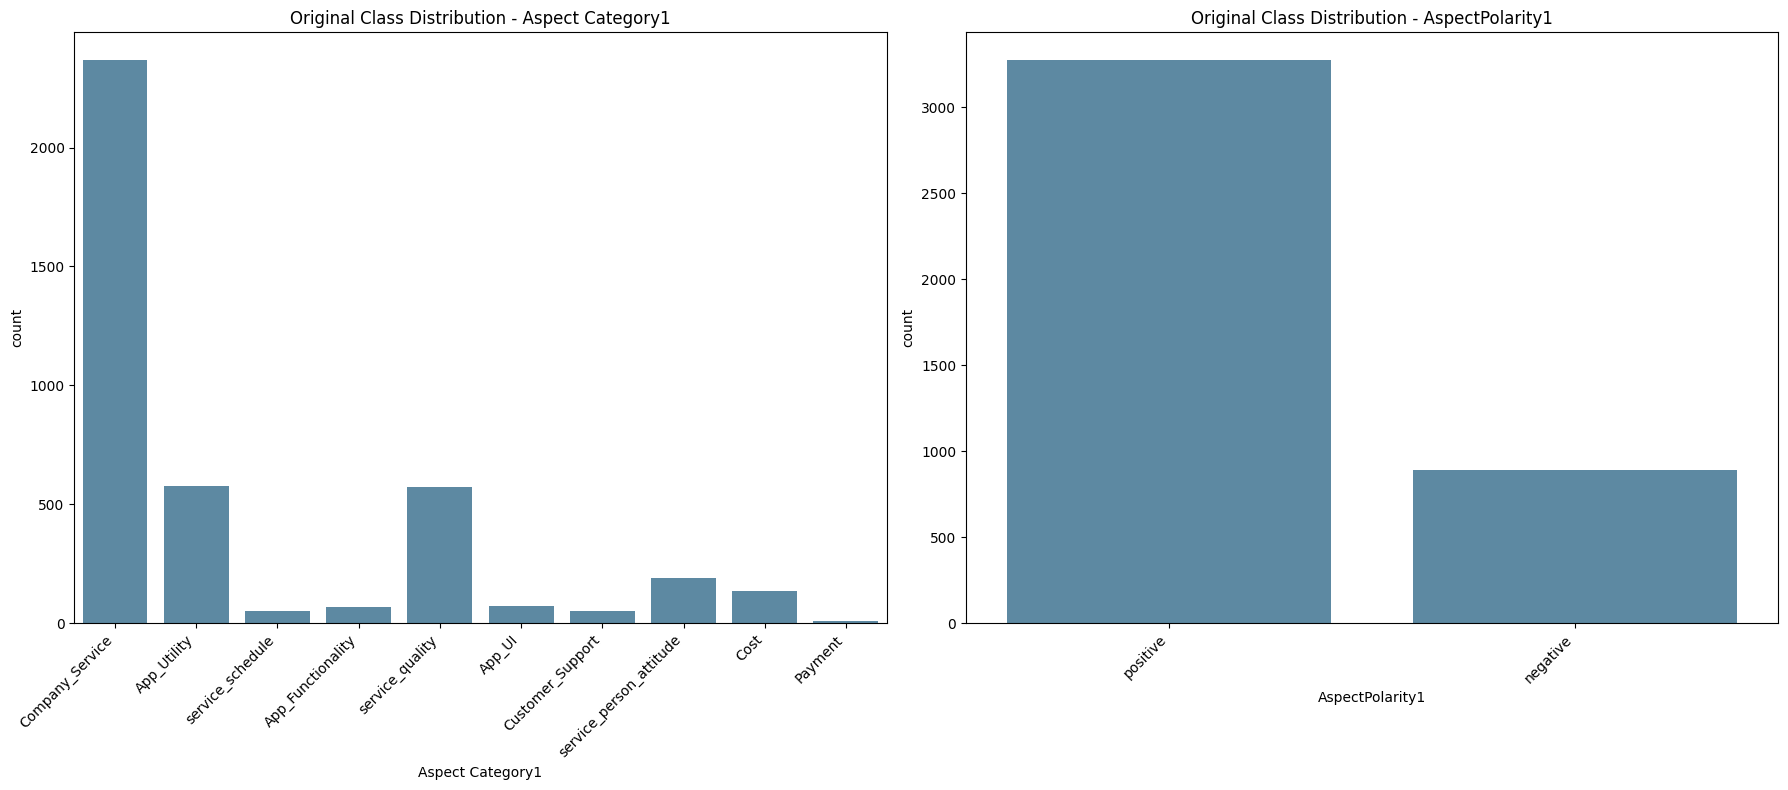

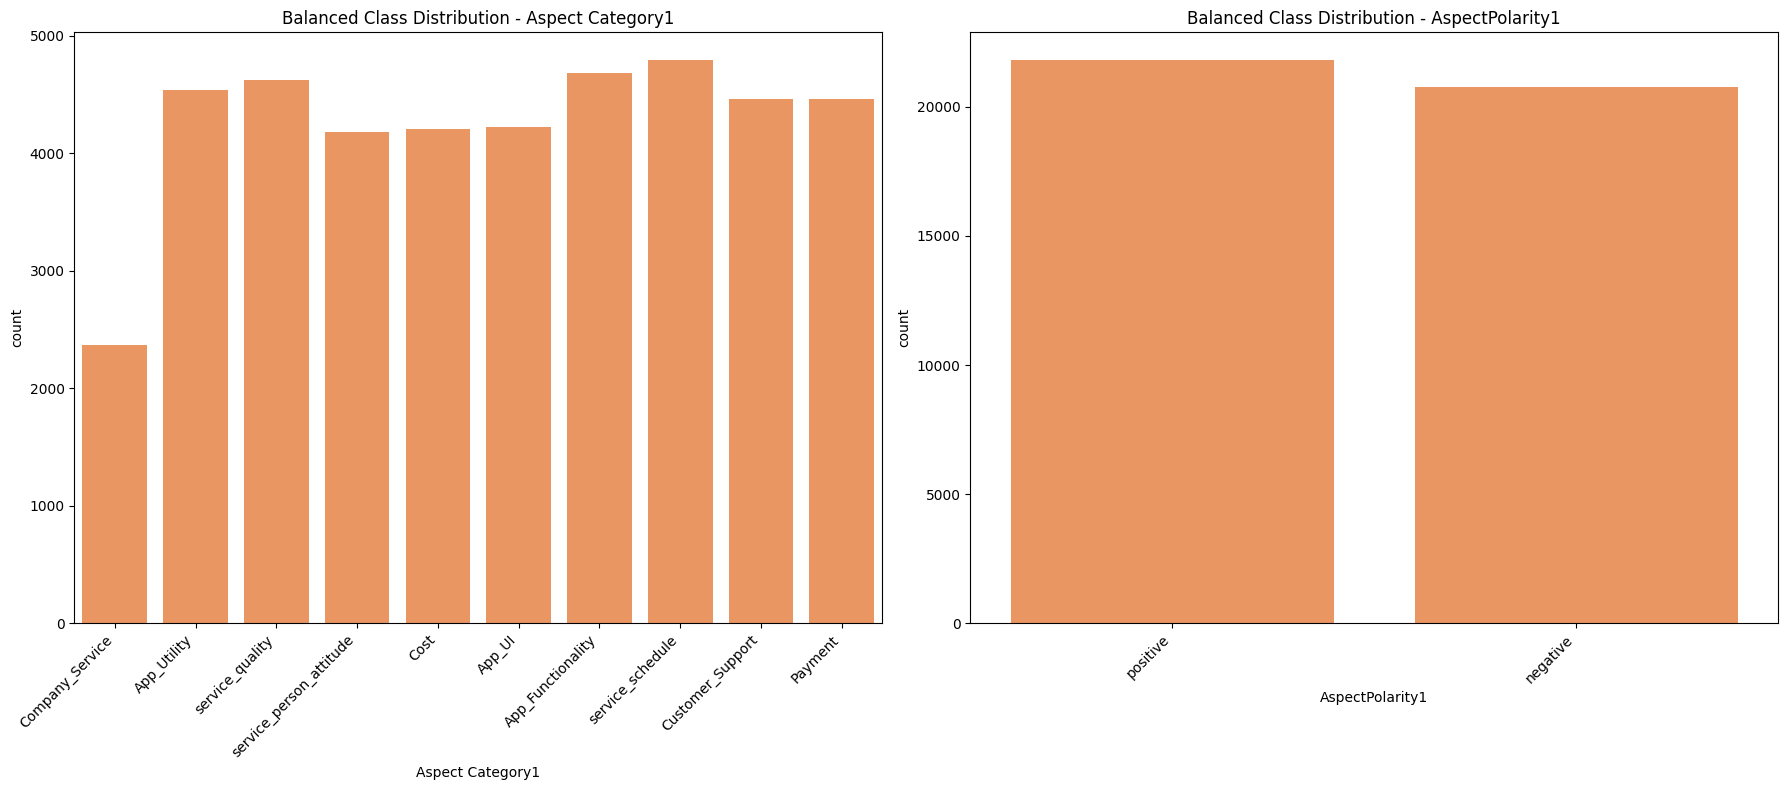

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Aspect Category1' and 'AspectPolarity1' are the columns with class labels in your 'raw_data'
category_counts_original = raw_data['Aspect Category1'].value_counts()
polarity_counts_original = raw_data['AspectPolarity1'].value_counts()

category_counts_upsampled = dataset['Aspect Category1'].value_counts()
polarity_counts_upsampled = dataset['AspectPolarity1'].value_counts()

# Plot for the original data
plt.figure(figsize=(18, 8))

# Plot for 'Aspect Category1'
plt.subplot(1, 2, 1)

# define colors for 'Aspect Category1' in the original data
colors_category_original = ['#528CAD' for _ in category_counts_original]

sns.countplot(x=raw_data['Aspect Category1'], data=raw_data, palette=colors_category_original)
plt.title('Original Class Distribution - Aspect Category1')
plt.xticks(rotation=45, ha='right')

# Plot for 'AspectPolarity1'
plt.subplot(1, 2, 2)

# define colors for 'AspectPolarity1' in the original data
colors_polarity_original = ['#528CAD' for _ in polarity_counts_original]

sns.countplot(x=raw_data['AspectPolarity1'], data=raw_data, palette=colors_polarity_original)
plt.title('Original Class Distribution - AspectPolarity1')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Plot for the upsampled data
plt.figure(figsize=(18, 8))

# Plot for 'Aspect Category1'
plt.subplot(1, 2, 1)

# define colors for 'Aspect Category1' in the upsampled data
colors_category_upsampled = ['#FF914D' for _ in category_counts_upsampled]

sns.countplot(x=dataset['Aspect Category1'], data=dataset, palette=colors_category_upsampled)
plt.title('Balanced Class Distribution - Aspect Category1')
plt.xticks(rotation=45, ha='right')

# Plot for 'AspectPolarity1'
plt.subplot(1, 2, 2)

# define colors for 'AspectPolarity1' in the upsampled data
colors_polarity_upsampled = ['#FF914D' for _ in polarity_counts_upsampled]

sns.countplot(x=dataset['AspectPolarity1'], data=dataset, palette=colors_polarity_upsampled)
plt.title('Balanced Class Distribution - AspectPolarity1')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
